# Analysis on the empirical networks: Internet and US Power Grid

In [1]:
# load what is necessary
library(igraph)
library(tidyverse)
library(ggplot2)
library(RColorBrewer)
library(rgl)
library(compiler)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.2.0     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::as_data_frame() masks tibble::as_data_frame(), igraph::as_data_frame()
✖ purrr::compose()       masks igraph::compose()
✖ tidyr::crossing()      masks igraph::crossing()
✖ dplyr::filter()        masks stats::filter()
✖ purrr::flatten()       masks jsonlite::flatten()
✖ dplyr::lag()           masks 

In [2]:
# the same function for the attacck protocols I just put the code here for
# consistency reasons there is only a slight modification in that the
# betweenness based attacks always trigger on the highest beteenness node

# please refer to 'attack_protocols.R' for comments on the code

survived <- function(g, alpha) {
    V(g)$load <- betweenness(g, v = V(g), directed = FALSE)
    V(g)$capacity <- (1 + alpha) * V(g)$load
    overloaded <- order(V(g)$load, decreasing = TRUE)[1]

    g_or <- g

    while (length(overloaded) > 0) {
        g_or <- delete_vertices(g_or, overloaded)
        V(g_or)$load <- betweenness(g_or, v = V(g_or), directed = FALSE)
        overloaded <- as.vector(V(g_or)[load > capacity])
    }


    n_prime <- max(components(g_or)$csize)
    n_orig <- max(components(g)$csize)

    return(n_prime/n_orig)
}
survived <- cmpfun(survived)

survived_deg <- function(g, alpha) {
    V(g)$load <- betweenness(g, v = V(g), directed = FALSE)
    V(g)$capacity <- (1 + alpha) * V(g)$load
    overloaded <- order(degree(g), decreasing = TRUE)[1]

    g_or <- g

    while (length(overloaded) > 0) {
        g_or <- delete_vertices(g_or, overloaded)
        V(g_or)$load <- betweenness(g_or, v = V(g_or), directed = FALSE)
        overloaded <- as.vector(V(g_or)[load > capacity])
    }


    n_prime <- max(components(g_or)$csize)
    n_orig <- max(components(g)$csize)

    return(n_prime/n_orig)
}
survived_deg <- cmpfun(survived_deg)

survived_random <- function(g, alpha) {
    V(g)$load <- betweenness(g, v = V(g), directed = FALSE)
    V(g)$capacity <- (1 + alpha) * V(g)$load
    overloaded <- sample(x = 1:length(g), size = 1)

    g_or <- g

    while (length(overloaded) > 0) {
        g_or <- delete_vertices(g_or, overloaded)
        V(g_or)$load <- betweenness(g_or, v = V(g_or), directed = FALSE)
        overloaded <- as.vector(V(g_or)[load > capacity])
    }


    n_prime <- max(components(g_or)$csize)
    n_orig <- max(components(g)$csize)

    return(n_prime/n_orig)
}
survived_random <- cmpfun(survived_random)

In [3]:
# create the palette to color code the nodes of highest betweenness
mypal <- rev(colorRampPalette(rev(c(brewer.pal(9, "OrRd"))))(20))
# plot(1, 1, type = "n", xlim = c(1, length(mypal)), ylim = c(1, 2), xlab = "", ylab = "")
# for (i in 1:length(mypal)) {
#   rect(i - 0.5, 1, i + 0.5, 2, col = mypal[i])
# }
# legend("topright", legend = mypal, fill = mypal, bg = "white")

In [4]:
# load the internet network and create the graph object
nodes <- read.csv("internet/nodes_clean.csv")
edges <- read.csv("internet/edges.csv")

el <- as.matrix(edges + 1)
g <- graph_from_edgelist(el = el, directed = FALSE)

In [5]:
# get the nodes position and create the layout to apply
layout <- as.matrix(nodes[, c(2, 3)], rownames.force = F)
# normalize to -1,1 interval
layout <- layout.norm(layout, -1, 1, -1, 1)

In [6]:
# compute the beweenness for all the nodes in the network
btw<-betweenness(g, normalized=FALSE,  directed = F)

# get the node id of the higher betweenness node
index <- which.max(btw)

# rescale the betweenness by a more appropriate function
btw_log <- log(1+btw)

# assing color id with palette by betweenness
btw_col_idx <- 1 + floor((19)*(btw_log - min(btw_log))/(max(btw_log)-min(btw_log)))
colors<-mypal[btw_col_idx]

In [7]:
# color nodes if they are neighbours to the highes betwe node
ei <- incident(g, index, mode = 'all')
E(g)$color_cst<-'grey' # default color
E(g)[ei]$color_cst<-'grey40'
E(g)[-ei]$color_cst<-'grey60'

In [8]:
# plot some info about the graph
g # get the number of nodes

mean(degree(g)) # reasonable number
sd(degree(g)) # high number: shows divergence as in scale free networks

IGRAPH aa0c5e7 U--- 6474 13895 -- 
+ attr: color_cst (e/c)
+ edges from aa0c5e7:
 [1] 1--3491 2-- 702 2--2915 2--2829 2-- 287 2-- 294 2--3562 2-- 726 2--2498
[10] 2--1240 2--1801 2-- 190 2--5728 2--5528 2--  87 2-- 914 2--2686 2--4002
[19] 2--1674 2--5007 2--4201 2--6462 2--2549 2--6302 2--5697 2-- 915 2--1741
[28] 2--4551 2--6454 2--6339 2--6202 2--5651 2--  72 2--  34 2--6135 2--4070
[37] 2--   4 2--3361 2--6173 2-- 201 2--1620 2-- 210 2--1692 2-- 920 2-- 156
[46] 2--3848 2--2114 2--3357 2--3915 2--6468 2--  33 2-- 175 2--5647 2-- 227
[55] 2--3162 2--3183 2--4566 2-- 689 2-- 437 2--2857 2--3550 2--1834 2--3138
[64] 2--3968 2--3304 2--5414 2--2951 2--3258 2-- 883 2--1622 2--2667 2--3411
+ ... omitted several edges

[1] 4.292555

[1] 25.08002

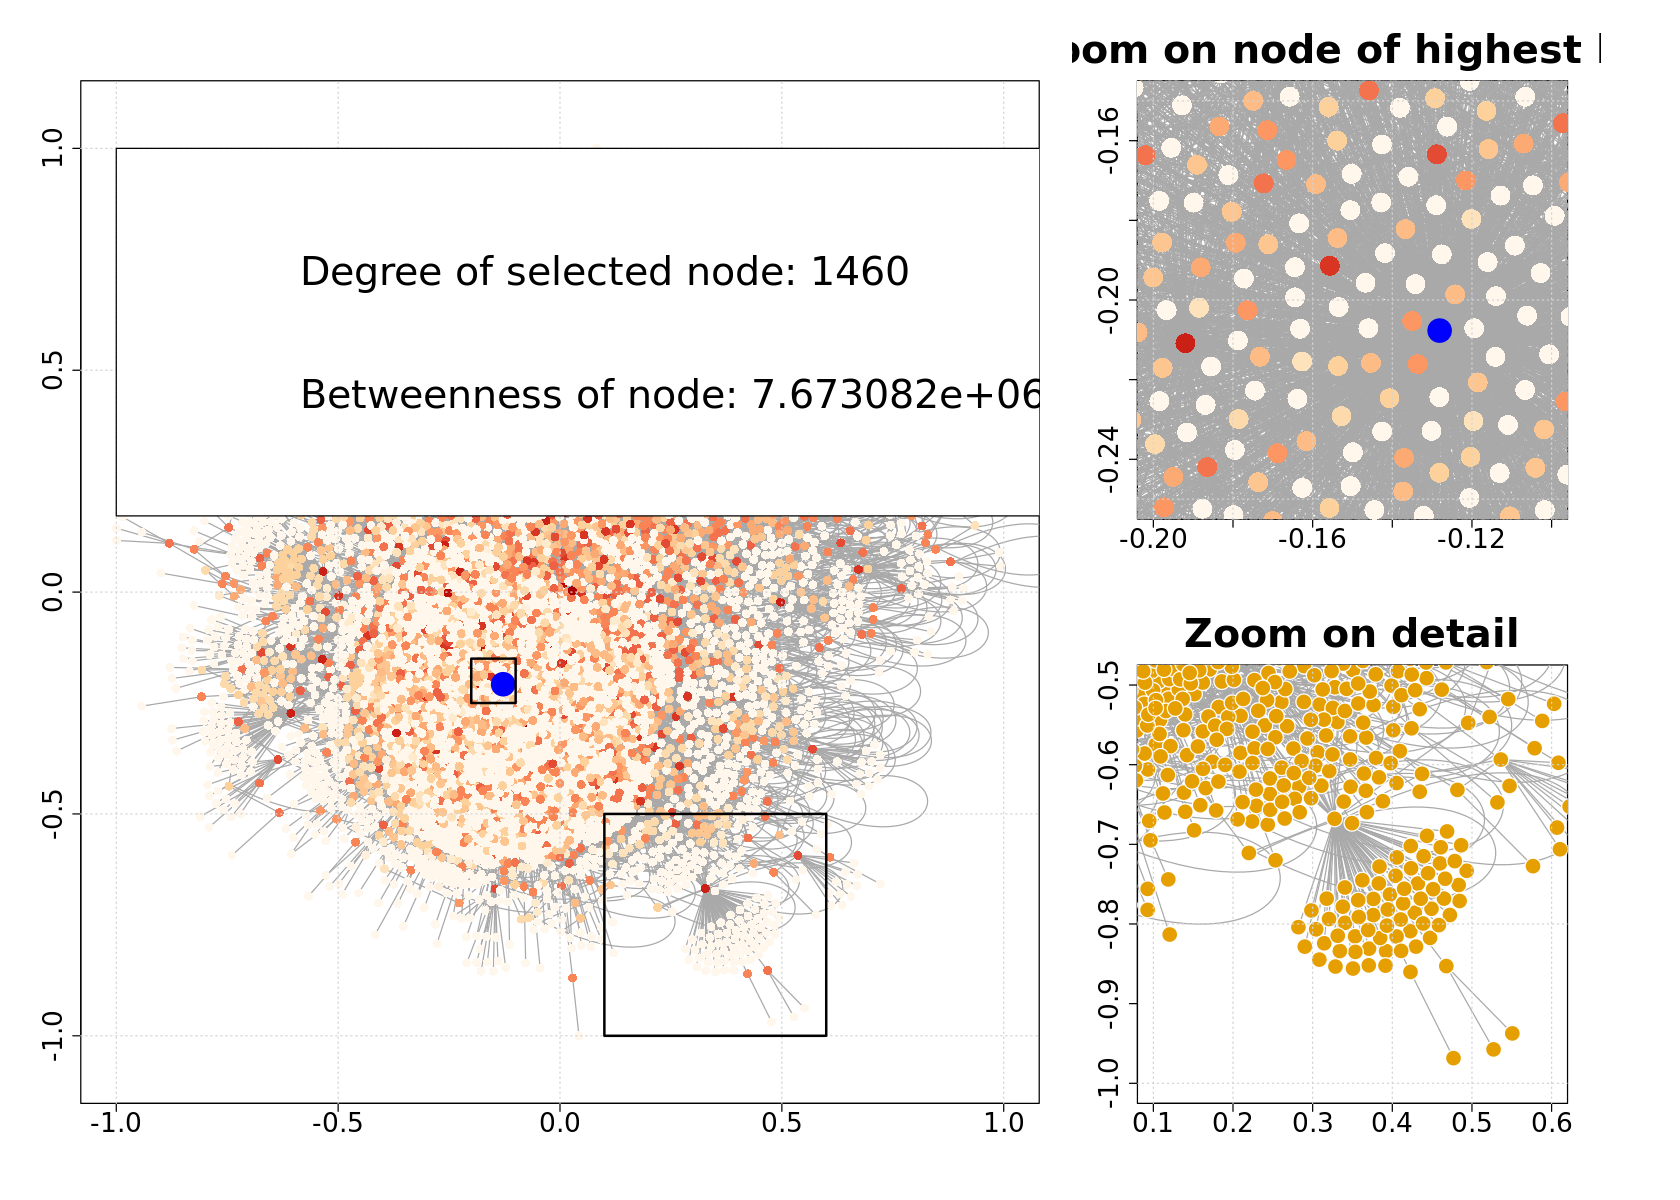

In [9]:
# get a nice plot of the network, it is color coded
# plotted on Jupyter very badly, but on pdf it works well

# decomment to save to file
# pdf("internet/whole_graph.pdf",width=14, height = 10)

# plotting options
options(repr.plot.width=14, repr.plot.height=10)
par(cex.axis=2, cex.lab = 4, cex.main=3, oma=c(1,1,1,5))
layout.matrix <- matrix(c(1, 1, 1, 1, 2, 3), nrow = 2, ncol = 3)
lay_plots<-layout(mat = layout.matrix)

# set the box positions for zooms
x_left_1<--0.2
x_right_1<--0.1
y_top_1<--0.15
y_bottom_1<--0.25

x_left_2<-0.1
x_right_2<-0.6
y_top_2<--0.5
y_bottom_2<--1

# actual plotting
plot(g, layout = layout,
     vertex.size = 2,
     vertex.frame.color = NA,
     vertex.color = colors,
     vertex.label = "", 
     edge.size = 0.1,
     edge.arrow.size = 0,
     axes = T,
     rescale=F )
points(layout[index,1], # show the highest betwe node as a point in the graph to highlight it
       layout[index,2],
       lwd=15,
       col='blue')
grid() # add a nice grid
rect(xleft = x_left_1, # show zoom region 1
     xright = x_right_1,
     ytop = y_top_1,
     ybottom = y_bottom_1,
     lwd = 2)
rect(xleft = x_left_2, # show zoom region 2
     xright = x_right_2,
     ybottom = y_bottom_2,
     ytop =y_top_2,
     lwd = 2)
legend(-1, 1, # add a legend with basic information
       legend=c(paste('Degree of selected node:', degree(g, v =index)),
                paste('Betweenness of node:', format(btw[index], scientific = TRUE))),
       bg='white',
       cex=3)

# plot first zoom
plot(g, layout = layout,
     vertex.size = 0.5,
     vertex.frame.color = NA, 
     vertex.color = colors,
     vertex.label = "",
     edge.size = 0.1,
     edge.arrow.size = 0,
     axes = T,
     main='Zoom on node of highest btw',
     xlim = c(x_left_1,x_right_1),
     ylim = c(y_bottom_1, y_top_1),
     rescale=F, asp=1 )
points(layout[index,1],
       layout[index,2],
       lwd=15, col='blue')
grid()

# third zoom on topological structure, it is just nice to look at
plot(g, layout = layout,
     vertex.size = 2, 
     vertex.frame.color = 0.1,
     vertex.label = "",
     edge.size = 0.1,
     edge.arrow.size = 0,
     axes = T,
     main='Zoom on detail',
     xlim = c(x_left_2,x_right_2),
     ylim = c(y_bottom_2, y_top_2),
     rescale=F, asp=1 )
grid()

# decomment to save to file
# dev.off()

In [10]:
# get the degree of all nodes and fit a power law to it
deg_graph<-degree(g)

fit_res<-fit_power_law(deg_graph, xmin = 1)

In [11]:
# power law function generator
f <- function(g, x) {
    function(x) {
        x^-g
    }
}

# for good plotting
f2<-f(2)
f3<-f(3)
f_c<-f(fit_res$alpha)

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”


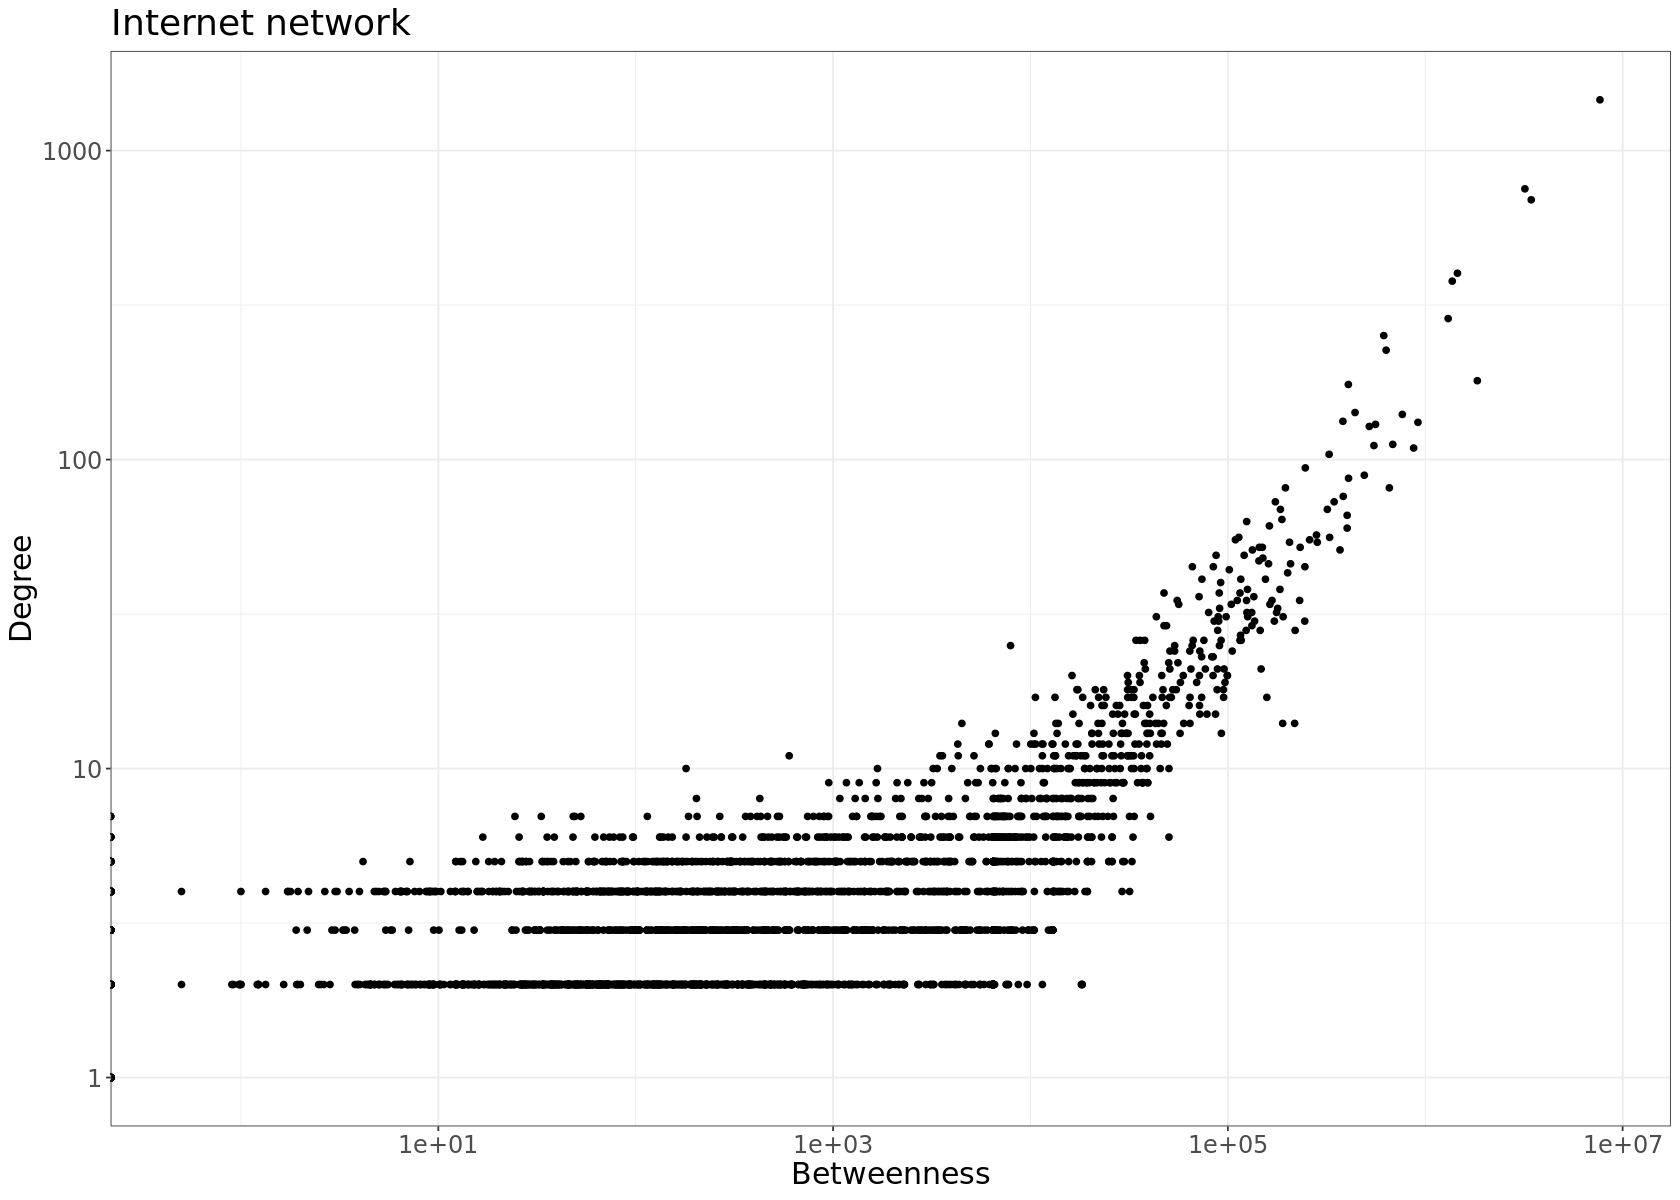

In [12]:
# plot the correlation betweenn degree and betweenness
densi<-data.frame(bet=btw, deg=degree(g))

bet_deg <- ggplot(densi, aes(x = btw, y = deg)) + geom_point() + scale_y_log10() +
    scale_x_log10() + theme_bw() + labs(x = "Betweenness", y = "Degree", title = "Internet network") +
    theme(text = element_text(size = 18))
bet_deg
ggsave(plot = bet_deg, filename = "internet/between_deg_correlation.pdf", width = 10,
    height = 7, scale = 0.75)

## Analysis of tear down at different $\alpha$
Refer to script for data generation

Here only the code for the graphs is shown

Warning message:
“Removed 11 rows containing missing values (`geom_segment()`).”


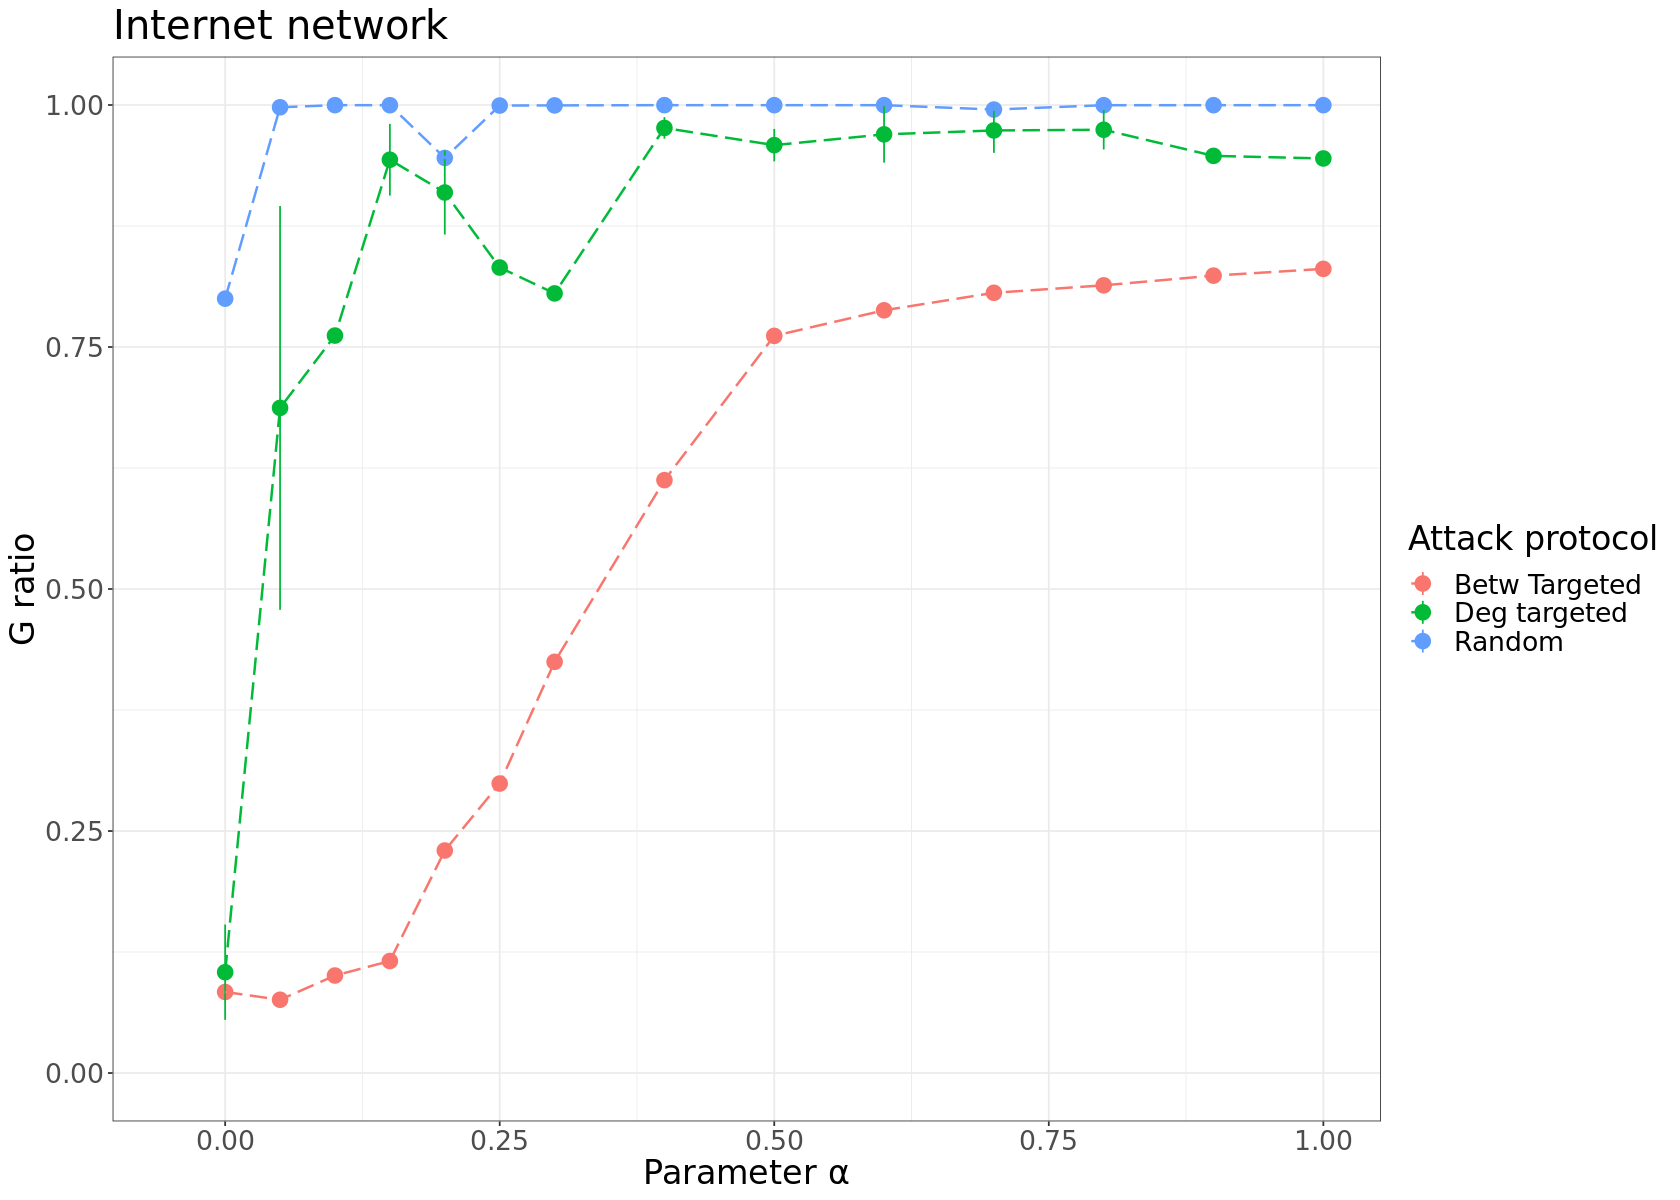

In [13]:
# read data
g_ratios<-read.csv('internet/plot_g.csv')

plot_conf <- ggplot(g_ratios) +
geom_point(aes(x = alpha,
               y = g_ratio,
               col = type),
           size = 4) +
geom_linerange(aes(x = alpha,
                   ymax = g_ratio + g_ratio_sd,
                   ymin = g_ratio - g_ratio_sd,
                   col = type)) +
geom_line(aes(x = alpha,
              y = g_ratio,
              col = type),
          linewidth = 0.7,
          linetype=5) +
scale_x_continuous(limits = c(-0.05, 1)) +
labs(x = expression(paste("Parameter ", alpha)),
     y = "G ratio", 
     col = "Attack protocol", title='Internet network') + 
theme_bw() +
theme(text = element_text(size = 20))+ylim(0, 1)

plot_conf

# decomment to save to file
# ggsave(plot = plot_conf, filename = 'internet/plot_g.pdf', width = 10, height = 7,
#     scale = 0.75)

## Detailed analysis for $\alpha=0.5$
Arbitrary choice to show what happens behind the curtain of the cascades failures

In [14]:
alpha<-0.5

In [15]:
# the following code is very simiar to the attack_protocol.R but is modified to
# be run line by line and save the ids of the failed nodes

# assign custom ids to keep track of the nodes; igraph automatically reassignes
# the ids after node deletion
V(g)$cst_ids <- 1:length(g)

V(g)$load <- betweenness(g, v = V(g), directed = FALSE)
V(g)$capacity <- (1 + alpha) * V(g)$load
overloaded <- order(V(g)$load, decreasing = TRUE)[1]

# to keep track of everything
dead_nodes <- overloaded

# a copy to check at the end of the process
g_or <- g

In [16]:
g_or <- delete_vertices(g_or, overloaded)
V(g_or)$load <- betweenness(g_or, v = V(g_or), directed = FALSE)
overloaded <- as.vector(V(g_or)[load > capacity])

In [17]:
# get the ids of the first failed nodes
orig_idx<-V(g_or)[overloaded]$cst_ids

In [18]:
orig_idx # check the first failed nodes

[1]    4   13   15   22   27   34   36   39   40   41   44   51   54   55   67
 [16]   72   73   74   85   88   89   94   97  106  107  109  110  121  124  134
 [31]  147  163  177  179  185  193  195  199  202  203  213  215  216  219  222
 [46]  226  238  239  252  257  261  272  276  282  284  289  291  301  302  307
 [61]  331  341  342  367  377  379  400  450  453  456  463  466  476  478  480
 [76]  492  499  502  503  504  514  519  520  535  543  580  582  583  586  624
 [91]  625  633  634  637  641  643  655  667  678  688  695  699  706  709  713
[106]  714  715  721  727  728  733  736  739  740  742  743  744  745  750  752
[121]  767  772  774  775  795  797  800  804  806  810  813  816  819  825  828
[136]  833  837  843  845  848  850  851  858  860  863  872  876  892  900  908
[151]  926  933  942  946  952  953  956  979  984  986  994 1013 1016 1020 1029
[166] 1060 1065 1066 1067 1089 1102 1126 1133 1136 1146 1156 1163 1167 1179 1180
[181] 1184 1190 1195 1199 1201 1214 1217 1221 1223 1225 1231 1235 1260 1269 1275
[196] 1323 1324 1326 1328 1333 1352 1358 1362 1363 1368 1370 1395 1404 1406 1408
[211] 1417 1428 1441 1458 1470 1484 1491 1502 1548 1550 1552 1553 1559 1567 1585
[226] 1594 1595 1600 1606 1610 1614 1616 1618 1621 1625 1629 1632 1637 1639 1646
[241] 1655 1662 1666 1672 1677 1695 1698 1699 1702 1708 1710 1713 1736 1748 1758
[256] 1780 1785 1797 1807 1812 1814 1817 1821 1822 1830 1838 1856 1877 1895 1913
[271] 1916 1920 1925 1929 1932 1933 1942 1945 1948 1954 1959 1962 1968 1978 1984
[286] 1987 1989 1993 1994 1998 2005 2006 2011 2013 2014 2015 2018 2028 2031 2034
[301] 2039 2040 2043 2056 2059 2060 2064 2067 2070 2073 2074 2089 2108 2126 2140
[316] 2142 2143 2144 2147 2167 2172 2177 2184 2203 2211 2229 2243 2244 2278 2289
[331] 2306 2317 2346 2358 2363 2367 2377 2380 2403 2418 2423 2431 2433 2435 2436
[346] 2448 2450 2463 2466 2467 2474 2484 2490 2494 2508 2549 2554 2562 2563 2569
[361] 2572 2581 2603 2605 2612 2619 2621 2631 2638 2647 2650 2664 2667 2673 2674
[376] 2680 2696 2721 2726 2732 2733 2735 2751 2759 2769 2782 2789 2799 2814 2850
[391] 2853 2870 2871 2879 2901 2902 2913 2917 2921 2925 2931 2946 2972 2980 2982
[406] 2990 2995 3018 3030 3055 3062 3066 3067 3070 3088 3092 3095 3104 3108 3133
[421] 3145 3157 3158 3161 3176 3183 3185 3197 3235 3248 3264 3265 3269 3273 3277
[436] 3299 3318 3330 3365 3366 3369 3375 3378 3382 3395 3399 3423 3427 3433 3440
[451] 3448 3453 3458 3462 3465 3491 3502 3507 3510 3515 3519 3521 3522 3523 3528
[466] 3536 3543 3548 3558 3559 3564 3567 3589 3595 3600 3601 3604 3605 3615 3618
[481] 3619 3628 3635 3639 3647 3649 3664 3668 3670 3673 3682 3700 3704 3727 3736
[496] 3737 3738 3751 3758 3767 3771 3782 3790 3791 3796 3797 3804 3805 3812 3832
[511] 3844 3845 3851 3867 3884 3894 3910 3925 3949 3978 3981 3988 3997 4006 4011
[526] 4038 4040 4050 4064 4070 4077 4086 4090 4092 4095 4121 4122 4136 4139 4146
[541] 4149 4155 4156 4160 4165 4169 4173 4180 4182 4199 4201 4204 4227 4229 4230
[556] 4239 4240 4241 4260 4269 4278 4289 4293 4294 4298 4311 4317 4334 4347 4356
[571] 4362 4363 4371 4381 4382 4423 4437 4441 4449 4455 4459 4478 4484 4500 4512
[586] 4513 4521 4528 4538 4589 4601 4633 4654 4681 4691 4737 4740 4751 4756 4770
[601] 4775 4798 4808 4815 4843 4852 4859 4877 4878 4888 4897 4903 4908 4909 4931
[616] 4942 4957 4958 4959 4968 4984 4986 4992 5050 5063 5066 5072 5073 5101 5110
[631] 5113 5118 5127 5133 5139 5146 5147 5150 5152 5154 5156 5160 5161 5171 5174
[646] 5179 5186 5200 5203 5212 5214 5217 5218 5221 5223 5225 5234 5239 5241 5243
[661] 5247 5248 5251 5254 5255 5270 5272 5277 5282 5287 5291 5292 5303 5305 5310
[676] 5327 5329 5332 5333 5334 5335 5355 5363 5366 5368 5369 5370 5374 5384 5385
[691] 5412 5417 5422 5430 5439 5441 5448 5453 5462 5467 5488 5505 5511 5517 5525
[706] 5543 5575 5585 5586 5609 5637 5640 5642 5645 5652 5662 5665 5671 5672 5674
[721] 5690 5693 5699 5700 5705 5711 5716 5717 5720 5727 5749 5755 5766 5768 5771
[736] 5772 5774 5778 5803 5819 58

In [19]:
dead_nodes<-c(dead_nodes, orig_idx) # save the progress

In [20]:
colors<-mypal[btw_col_idx] # compute the original palette again

In [21]:
# assing color to palette depending on the node status: first failed, trigger or other
colors[orig_idx]<-'#5765ff'
colors[-orig_idx]<-'#f7be60'
colors[index]<-'red'

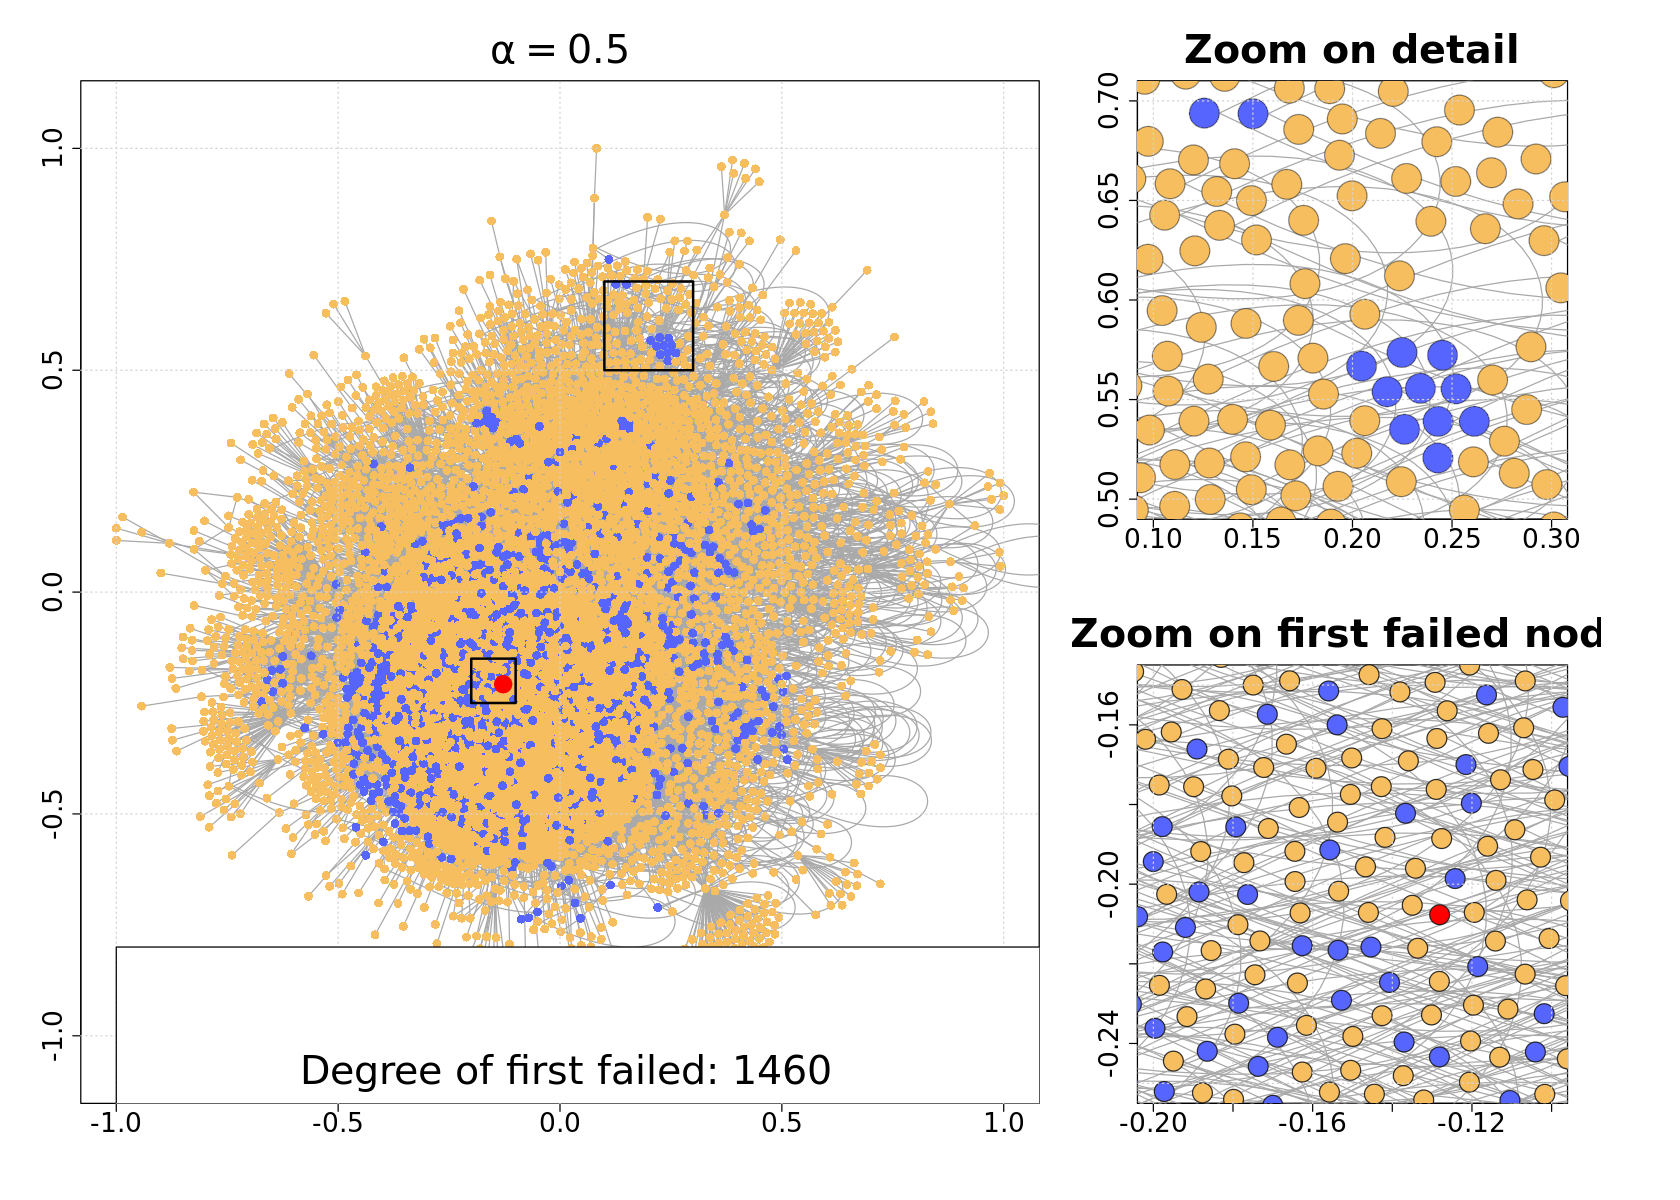

In [22]:
# same as above, but different colors

# pdf("internet/whole_graph_failing_new.pdf",width=14, height = 10) 
options(repr.plot.width=14, repr.plot.height=10)
par(cex.axis=2, cex.lab = 4, cex.main=3, oma=c(1,1,1,5))
layout.matrix <- matrix(c(1, 1, 1, 1, 2, 3), nrow = 2, ncol = 3)
lay_plots<-layout(mat = layout.matrix)

x_left_2<--0.2
x_right_2<--0.1
y_top_2<--0.15
y_bottom_2<--0.25

x_left_1<-0.1
x_right_1<-0.3
y_top_1<-0.7
y_bottom_1<-0.5

plot(g, layout = layout,
     vertex.size = 2,
     vertex.frame.color = NA,
     vertex.color = colors,
    vertex.label = "",
     edge.size = 0.05,
     edge.arrow.size = 0,
     axes = T,
     main=expression(paste(alpha==0.5)),
     rescale=F )

points(layout[index,1],
       layout[index,2],
       lwd=10, col='red')
grid()
rect(xleft = x_left_1,
     xright = x_right_1,
     ytop = y_top_1,
     ybottom = y_bottom_1,
     lwd = 2)
rect(xleft = x_left_2,
     xright = x_right_2,
     ybottom = y_bottom_2, 
     ytop =y_top_2,
     lwd = 2)
legend(-1, -0.8,
       legend = c(paste("Degree of first failed:", degree(g)[index]),
                  paste("Affected nodes:",length(dead_nodes))),
       bg='white', cex=3)


plot(g, layout = layout,
     vertex.size = 1.5, 
     vertex.frame.color = alpha('grey10',0.5),
     vertex.color = colors,
     vertex.label = "",
     edge.width = NA, 
     edge.arrow.size = 0,
     axes = T,main='Zoom on detail',
     xlim = c(x_left_1,x_right_1),
     ylim = c(y_bottom_1, y_top_1),
     rescale=F, asp=1 )

points(layout[index,1],
       layout[index,2],
       lwd=15, col='red')
grid()

plot(g, layout = layout,
     vertex.size = 0.5, 
     vertex.frame.color = alpha('grey10',0.9),
     vertex.color = colors,
     vertex.label = "", 
     edge.arrow.size = 0, 
     edge.width=NA,
     axes = T, main='Zoom on first failed node',
     xlim = c(x_left_2,x_right_2),
     ylim = c(y_bottom_2, y_top_2),
     rescale=F, asp=1 )

grid()
# dev.off()

In [23]:
# now destroy everything from the original network

V(g)$load <- betweenness(g, v = V(g), directed = FALSE)
V(g)$capacity <- (1 + alpha) * V(g)$load
overloaded <- order(V(g)$load, decreasing = TRUE)[1]

dead_nodes<-overloaded
g_or <- g

while (length(overloaded) > 0) {
    g_or <- delete_vertices(g_or, overloaded)
    V(g_or)$load <- betweenness(g_or, v = V(g_or), directed = FALSE)
    overloaded <- as.vector(V(g_or)[load > capacity])
    orig_idx<-V(g_or)[overloaded]$cst_ids
    dead_nodes<-c(dead_nodes, orig_idx)
}

n_prime <- max(components(g_or)$csize)
n_orig <- max(components(g)$csize)

In [24]:
# get the ids of the lcc in the remaining network
biggest_cluster_id <- which.max(components(g_or)$csize)
vert_ids <- V(g_or)[components(g_or)$membership == biggest_cluster_id]

llc_id<-V(g_or)[vert_ids]$cst_ids

In [25]:
# set the colors once again
colors[dead_nodes]<-'#5765ff'
colors[-dead_nodes]<-'#f7be60'
colors[index]<-'red'
colors[llc_id]<-'#11d417'

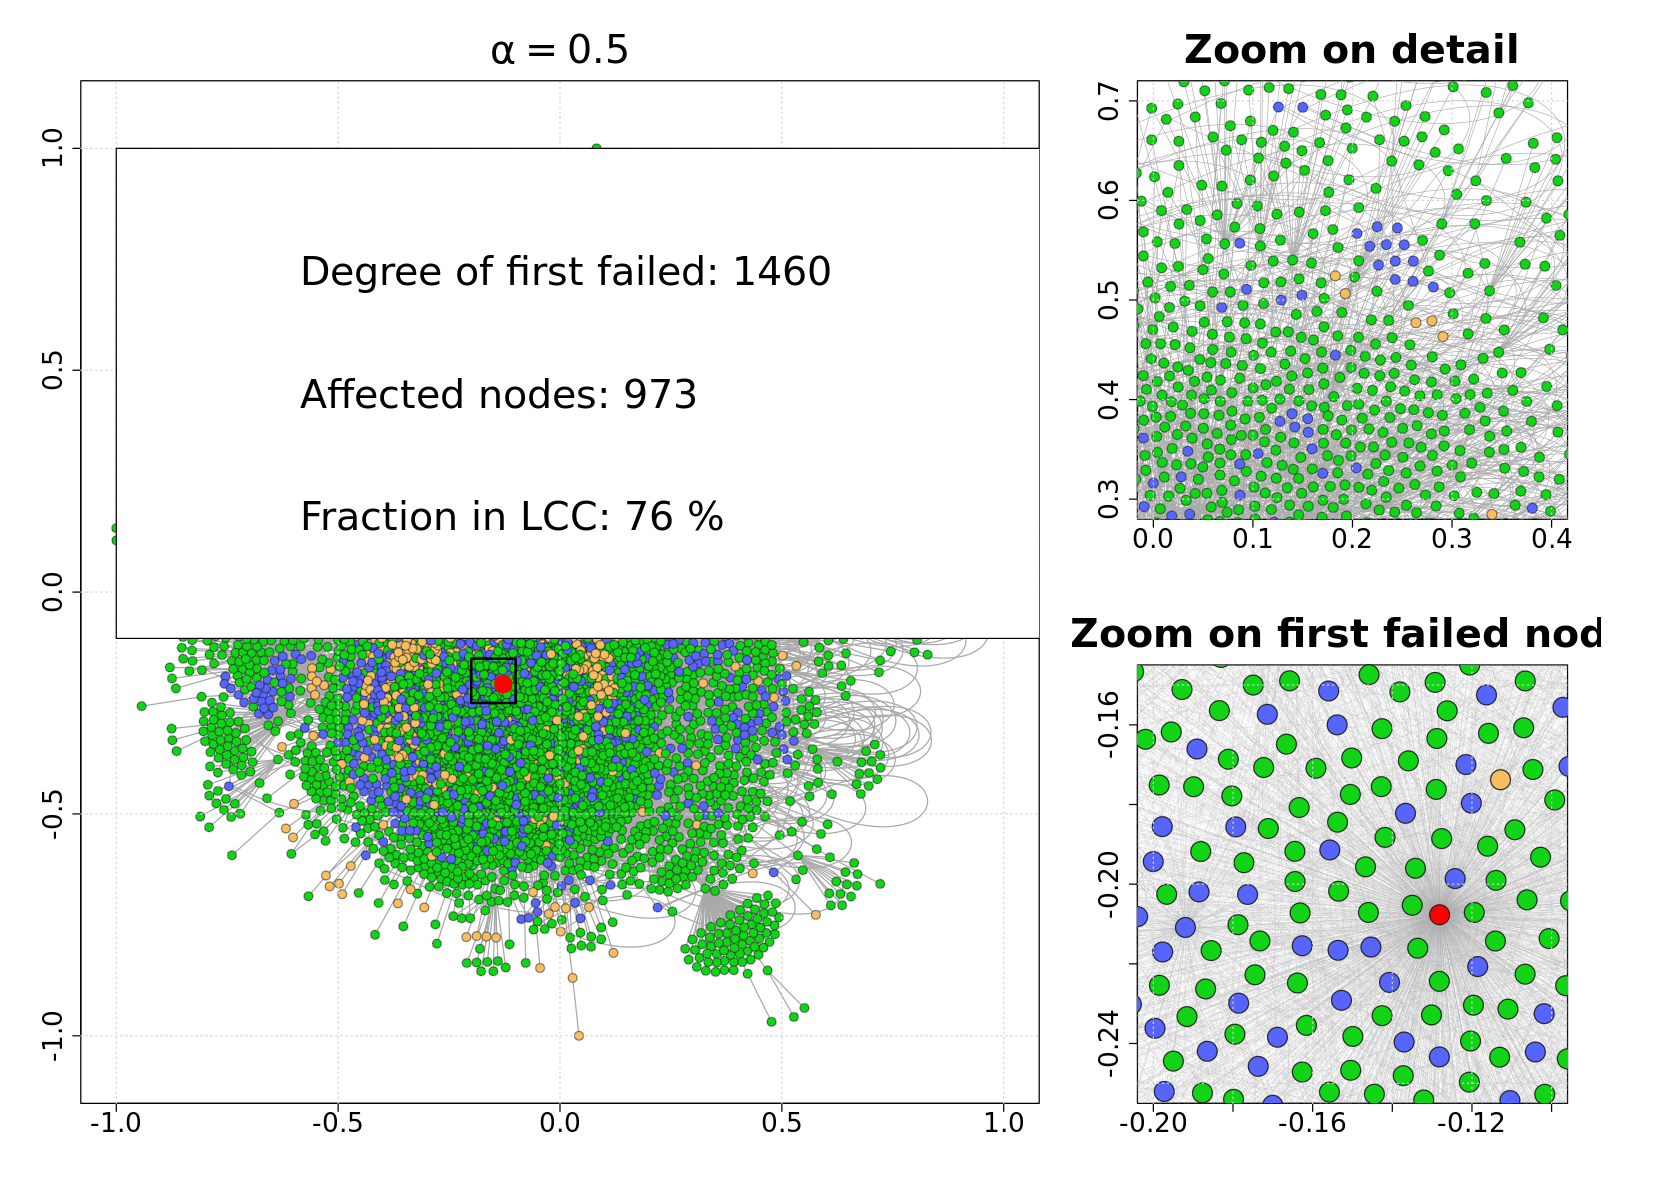

In [26]:
# pdf("internet/whole_graph_failing_all.pdf",width=14, height = 10) 
options(repr.plot.width=14, repr.plot.height=10)
par(cex.axis=2, cex.lab = 4, cex.main=3, oma=c(1,1,1,5))
layout.matrix <- matrix(c(1, 1, 1, 1, 2, 3), nrow = 2, ncol = 3)
lay_plots<-layout(mat = layout.matrix)


x_left_1<-0.
x_right_1<-0.4
y_top_1<-0.7
y_bottom_1<-0.3

x_left_2<--0.2
x_right_2<--0.1
y_top_2<--0.15
y_bottom_2<--0.25


plot(g, layout = layout,
     vertex.size = 2, 
     vertex.frame.color =alpha('grey10',0.5), 
     vertex.color = colors,
     vertex.label = "",
     edge.size = 0.1,
     edge.arrow.size = 0,
     axes = T,
     main=expression(paste(alpha==0.5)),
     rescale=F )
points(layout[index,1], 
       layout[index,2],
       lwd=10, col='red')
grid()
rect(xleft = x_left_1,
     xright = x_right_1,
     ytop = y_top_1,
     ybottom = y_bottom_1,
     lwd = 2)
rect(xleft = x_left_2, 
     xright = x_right_2,
     ybottom = y_bottom_2,
     ytop =y_top_2,
     lwd = 2)
legend(-1, 1,
       legend = c(paste("Degree of first failed:", degree(g)[index]),
                  paste("Affected nodes:",length(dead_nodes)),
                  paste('Fraction in LCC:', round(n_prime/n_orig,2)*100, '%')),
       bg='white', cex=3)

plot(g, layout = layout,
     vertex.size = 1,
     vertex.frame.color = alpha('grey10',0.5),
     vertex.color = colors,
     vertex.label = "",
     edge.width = 0.5,
     edge.arrow.size = 0,
     axes = T,main='Zoom on detail',
     xlim = c(x_left_1,x_right_1),
     ylim = c(y_bottom_1, y_top_1),
     rescale=F, asp=1 )
points(layout[index,1],
       layout[index,2],
       lwd=15, col='red')
grid()

plot(g, layout = layout,
     vertex.size = 0.5,
     vertex.frame.color = alpha('grey10',0.9),
     vertex.color = colors,
     vertex.label = "",
     edge.width = 0.1, 
     edge.arrow.size = 0,
     axes = T, main='Zoom on first failed node',
     xlim = c(x_left_2,x_right_2),
     ylim = c(y_bottom_2, y_top_2),
     rescale=F, asp=1 )

grid()
# dev.off()

## Now do the same analysis but with the configuration model on the degree sequence from the Internet network

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”
Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_line()`).”


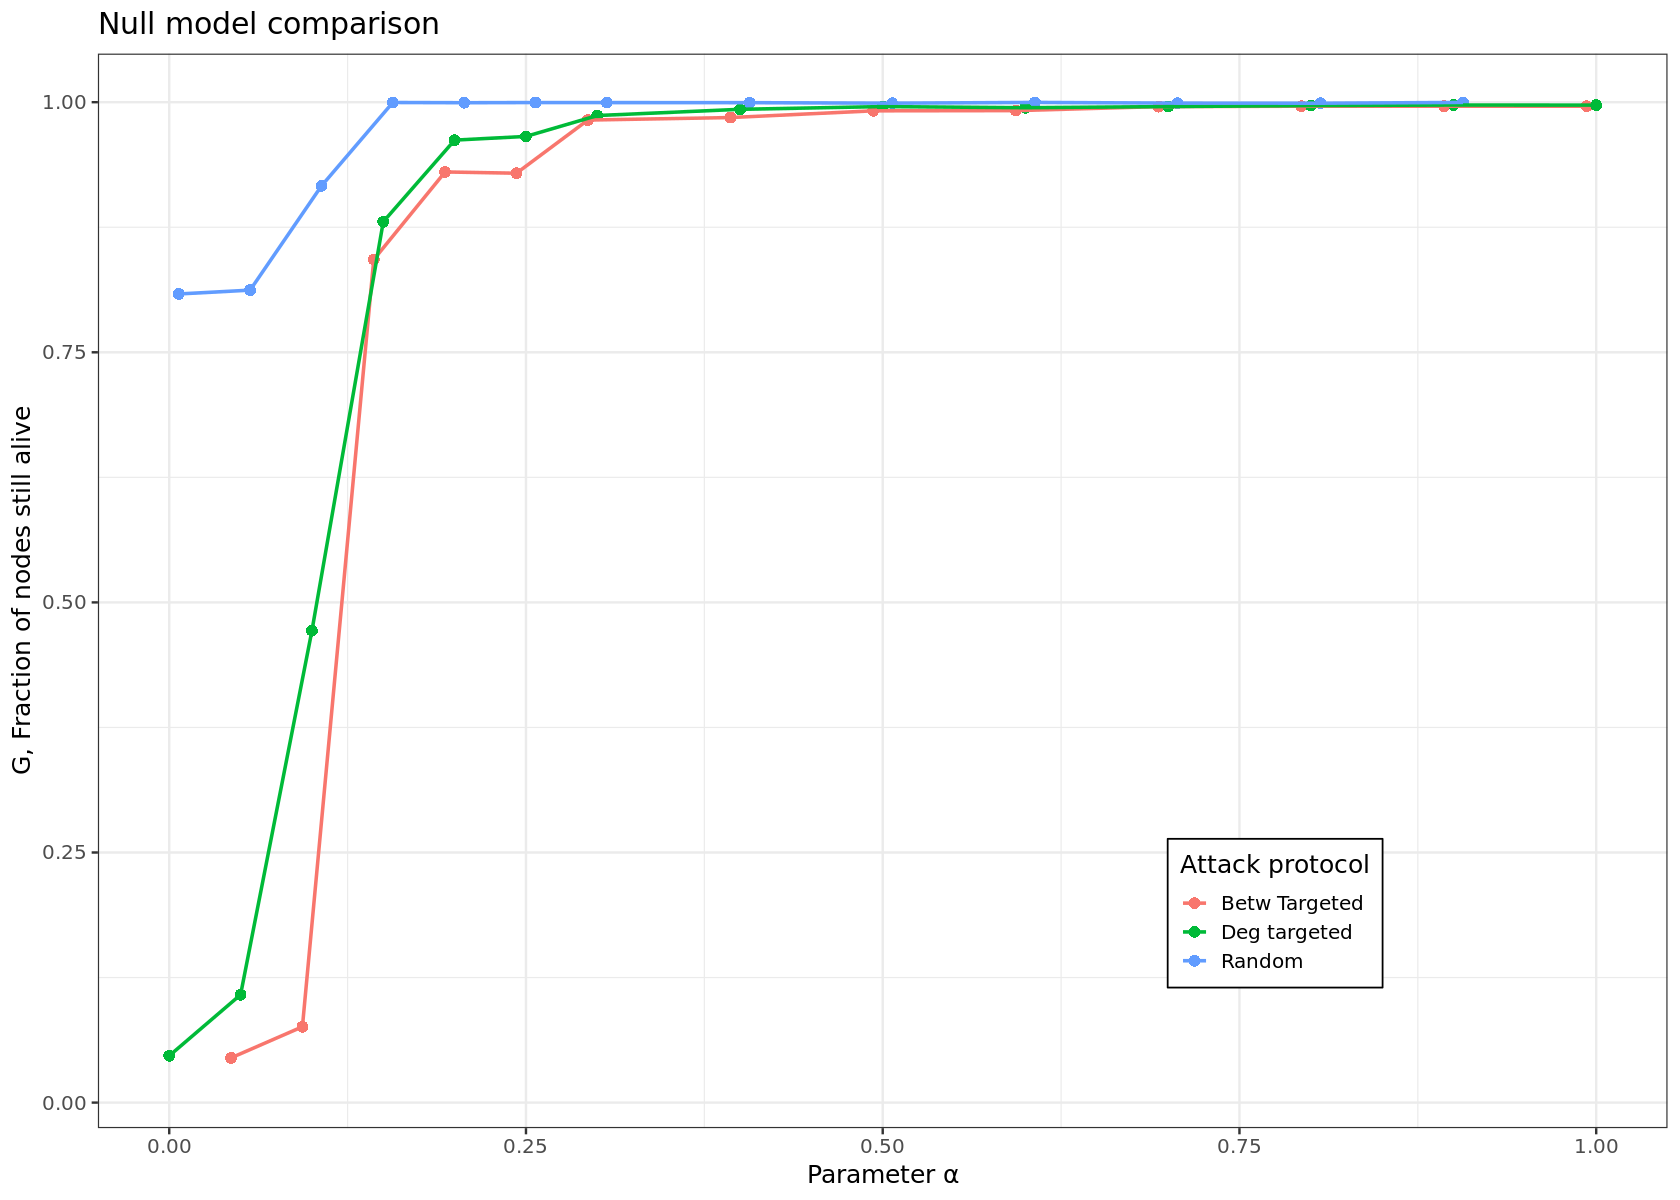

In [27]:
conf <- read.csv("power/null_config.csv")

plot_conf <- ggplot(conf) + geom_point(aes(x = alpha, y = g_ratio, col = type), position = position_dodge(0.02),
    shape = 16, size = 3) + geom_line(aes(x = alpha, y = g_ratio, col = type), linewidth = 1,
    position = position_dodge(0.02)) + scale_x_continuous(limits = c(0, 1)) + labs(x = expression(paste("Parameter ",
    alpha)), y = "G, Fraction of nodes still alive", title = "Null model comparison",
    col = "Attack protocol") + theme_bw(base_size = 15) + theme(legend.position = c(0.75,
    0.2), legend.background = element_rect(size = 0.5, linetype = "solid", colour = "black"))

plot_conf

# ggsave(plot = plot_conf, filename = 'power/plot_conf.pdf', width = 7, height = 5)